In [1]:
%run PVModel_functions.ipynb

In [2]:
#This cell imports all the necessary packages & module data
import pandas as pd 
import numpy as np
from datetime import datetime
import datatools
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime
import pvlib
import pvanalytics
import math
import pvpltools
import seaborn as sns
from pvpltools import iec61853
from pvpltools.module_efficiency import adr, heydenreich, motherpv, pvgis, mpm5, mpm6, bilinear
from pvpltools.module_efficiency import fit_efficiency_model, fit_bilinear

%matplotlib inline 
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

mpl.rcParams['font.size']=12
mpl.rcParams['lines.linewidth']=1
mpl.rcParams['xtick.labelsize']=10
#mpl.rcParams['font.weight']='bold'
mpl.rcParams['axes.titlesize']=22

In [3]:
#This is where all the input info should be
#Valid module names : LG, Panasonic, Can270, Can275, HanQPlus, HanQPeak, MissionSolar, Jinko
#Valid sys table names: dbo.PVLT_Pan_LG_Panasonic_LG,dbo.PVLT_Can_Han_Canadian_Hanwha,
#                       dbo.PVLT_TrinaJinko_Jinko, dbo.PVLT_MissionSolar_MissionSolar

mod_name = 'Panasonic'
mettablename =  'dbo.SNLA_Met_DataOut'

In [4]:
#Reads in an excel file of all necessary module coefficients, string lengths, system dates, etc
mod_info = pd.read_excel('module_coefficients.xlsx')
mod_info.index = mod_info['Manufacturer']
del mod_info['Manufacturer']
#defines the specific module given the previous user input and module coefficients file
module = mod_info[mod_name]
systablename = module['table_name']
start = '2020-01-01 00:00:00-07:00'
 #module['start']
end = '2021-01-01 00:00:00-07:00'
#module['end']

In [115]:
#Import sys & met databases & merge into one df
df = sys_met_data(mettablename, systablename, start, end)

In [116]:
#Calculate solpos & other environmental data, like airmass, aoi, and differnt poa components
sdf = calc_sol_data(df.index, module['latitude'], module['longitude'], module['tilt'], df['Pressure_mBar_Avg'])
edf = calc_env_data(module['tilt'], module ['altitude'], module['surface_azimuth'], sdf['azimuth'], sdf['apparent_zenith'], 
               df['Direct_Wm2_Avg'], df['Global_Wm2_Avg'], df['Diffuse_Wm2_Avg'], sdf['dni_extra'], model = 'haydavies')
edf['am_abs'] = pvlib.atmosphere.get_absolute_airmass(edf['airmass'], edf['pressure'])
#merge this information into one solar & environmental data df called 'sedf'
sedf = pd.merge(edf,sdf,how='inner', left_index=True, right_index=True)

In [15]:
strings = ['str_1_rtd', 'str_2_rtd', 'str_3_rtd', 'str_4_rtd']
measureds = ['Str_1', 'Str_2', 'Str_3', 'Str_4']
col_1s = ['SAM', 'SAPM', 'PVWatts str_1_rtd', 'CEC str_1_rtd', 'Desoto str_1_rtd', 'PVSyst str_1_rtd', 'ADR str_1_rtd', 'Heydenreich str_1_rtd', 'Mother str_1_rtd', 'PVGIS str_1_rtd', 'MPM5 str_1_rtd','MPM6 str_1_rtd']
col_2s = ['SAM', 'SAPM', 'PVWatts str_2_rtd', 'CEC str_2_rtd', 'Desoto str_2_rtd', 'PVSyst str_2_rtd', 'ADR str_2_rtd', 'Heydenreich str_2_rtd', 'Mother str_2_rtd', 'PVGIS str_2_rtd', 'MPM5 str_2_rtd','MPM6 str_2_rtd']
col_3s = ['SAM', 'SAPM', 'PVWatts str_3_rtd', 'CEC str_3_rtd', 'Desoto str_3_rtd', 'PVSyst str_3_rtd', 'ADR str_3_rtd', 'Heydenreich str_3_rtd', 'Mother str_3_rtd', 'PVGIS str_3_rtd', 'MPM5 str_3_rtd','MPM6 str_3_rtd']
col_4s = ['SAM', 'SAPM', 'PVWatts str_4_rtd', 'CEC str_4_rtd', 'Desoto str_4_rtd', 'PVSyst str_4_rtd', 'ADR str_4_rtd', 'Heydenreich str_4_rtd', 'Mother str_4_rtd', 'PVGIS str_4_rtd', 'MPM5 str_4_rtd','MPM6 str_4_rtd']


In [117]:
#Generate a results dataframe and add measured values
results = meas_val(df[module['str_1_v']],df[module['str_1_i']]).to_frame()
results['Str_2'] = meas_val(df[module['str_2_v']],df[module['str_2_i']])
results['Str_3'] = meas_val(df[module['str_3_v']],df[module['str_3_i']])
results['Str_4'] = meas_val(df[module['str_4_v']],df[module['str_4_i']])
results = results.resample('H').mean()
results.rename(columns = { 0 : 'Str_1'}, inplace = True)

In [17]:
#df.loc[df['BroadbandPOA_Avg']<0, 'BroadbandPOA_Avg'] = 0

In [118]:
#read in SAM data from the spreadsheet containing all SAM results for entire time period of system
sam_data = pd.read_excel('SAM_results.xlsx', sheet_name = [mod_name])
sam_data = sam_data[mod_name]
sam_data.index = sam_data['Time']
sam_data.index = pd.DatetimeIndex(sam_data.index)
del sam_data['Time']
sam_data.rename(columns = {mod_name : 'SAM'}, inplace = True)
sam_data = sam_data.loc[start:end, :]
results ['SAM'] = sam_data['SAM']#.resample('M').mean()

In [119]:
#Calcualte SAPM results and add to df
sapm_par = sapm_param(sedf['poa_global'], edf['poa_direct'], edf['poa_diffuse'], df.AmbientTemp_Avg, df.Wind_Speed_Avg, 
                   sedf['am_abs'], sedf['aoi'], module)
dc = sapm(sapm_par['eff_irr'], sapm_par['tcell'], module)
results['SAPM'] = sapm_p(dc['v_mp'], dc['i_mp'], module['str_len'])#.resample('M').mean()

In [120]:
sapm_tcell = sapm_par['tcell'].to_frame()
df = df.merge(sapm_tcell,how = 'inner', left_index=True, right_index=True)
df = df[~df.index.duplicated(keep='first')]

In [122]:
df['tcell']

TmStamp
2020-01-01 00:00:00-07:00    1.284764
2020-01-01 00:01:00-07:00    1.232654
2020-01-01 00:02:00-07:00    1.197850
2020-01-01 00:03:00-07:00    1.224664
2020-01-01 00:04:00-07:00    1.232877
                               ...   
2020-12-31 23:56:00-07:00   -1.340180
2020-12-31 23:57:00-07:00   -1.157307
2020-12-31 23:58:00-07:00   -1.211823
2020-12-31 23:59:00-07:00   -1.365038
2021-01-01 00:00:00-07:00   -1.476716
Name: tcell, Length: 526741, dtype: float64

In [124]:
sapm_par['tcell']

TmStamp
2020-01-01 00:00:00-07:00    1.284764
2020-01-01 00:01:00-07:00    1.232654
2020-01-01 00:02:00-07:00    1.197850
2020-01-01 00:03:00-07:00    1.224664
2020-01-01 00:04:00-07:00    1.232877
                               ...   
2020-12-31 23:56:00-07:00   -1.340180
2020-12-31 23:57:00-07:00   -1.157307
2020-12-31 23:58:00-07:00   -1.211823
2020-12-31 23:59:00-07:00   -1.365038
2021-01-01 00:00:00-07:00   -1.476716
Name: tcell, Length: 526867, dtype: float64

In [56]:
#Calculate PVWatts results and add to df
results['PVWatts'] = (pvwatts(POA_eff = df['BroadbandPOA_Avg'], cell_temp = df['tcell'], 
                             stc_mod_p = module['Power'], Gpmp = module['Gpmp'],str_len = module['str_len'],
                                                 temp_ref=25.0 ))#.resample('M').mean()

In [125]:
#Calculate CEC results and add to df
cec_param = pvlib.pvsystem.calcparams_cec( df['BroadbandPOA_Avg'], df['tcell'], module['alpha_sc'], 
                                          module['a_ref'], module['I_L_ref'], module['I_o_ref'], module['R_sh_ref'], 
                                          module['R_s'], module['Adjust'], module['Cells_in_Series'])
cec_p = pvlib.pvsystem.singlediode(photocurrent = cec_param[0], saturation_current = cec_param[1], resistance_series =
                           cec_param[2], resistance_shunt = cec_param[3], nNsVth = cec_param[4])
results['CEC'] = sdm(cec_p['p_mp'], module['str_len'])#.resample('M').mean()

C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\pvlib\singlediode.py:613: RuntimeWarning: overflow encountered in exp
  np.exp((Rs[idx_p] * (IL[idx_p] + I0[idx_p]) + V[idx_p]) /


Exception: EXCEPTION:iterations exceeded maximum (50)

In [133]:
#Calculate Desoto results and add to df
ds_param = pvlib.pvsystem.calcparams_desoto(df['BroadbandPOA_Avg'], df['tcell'], module['alpha_sc'],
                                            module['a_ref'],module['I_L_ref'], module['I_o_ref'], 
                                            module['R_sh_ref'], module['R_s'])
ds_p = pvlib.pvsystem.singlediode(photocurrent = ds_param[0], saturation_current = ds_param[1], resistance_series =
                           ds_param[2], resistance_shunt = ds_param[3], nNsVth = ds_param[4])
results['Desoto'] = sdm(ds_p['p_mp'], module['str_len'])#.resample('M').mean()

C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\pvlib\singlediode.py:613: RuntimeWarning: overflow encountered in exp
  np.exp((Rs[idx_p] * (IL[idx_p] + I0[idx_p]) + V[idx_p]) /


Exception: EXCEPTION:iterations exceeded maximum (50)

In [134]:
#Calculte PVSystem results and add to df
pvs_param = pvlib.pvsystem.calcparams_pvsyst(df['BroadbandPOA_Avg'],df['tcell'], module['alpha_sc'], 
                                             module['gamma_ref'],module['mu_gamma'], module['I_L_ref'], module['I_o_ref'],
                                             module['R_sh_ref'], module['R_sh_0'], module['R_s'],  module['Cells_in_Series'])
pvs_p = pvlib.pvsystem.singlediode(photocurrent = pvs_param[0], saturation_current = pvs_param[1], resistance_series =
                           pvs_param[2], resistance_shunt = pvs_param[3], nNsVth = pvs_param[4])
results['PVSyst'] = sdm(pvs_p['p_mp'], module['str_len'])#.resample('M').mean()

C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\pvlib\singlediode.py:550: RuntimeWarning: invalid value encountered in log
  np.log(a[idx_p]) +


Exception: EXCEPTION:iterations exceeded maximum (50)

In [126]:
#Import matrix of measurement data
measurements_file = 'Sandia_PV_Module_P-Matrix-and-TempCo-Data_2019.xlsx'
matrix = pd.read_excel(measurements_file, sheet_name = mod_name, usecols='B,C,H', header=None, skiprows=5, nrows=27)
matrix.columns = ['temperature', 'irradiance', 'p_mp']
# calculate efficiency from power
matrix = matrix.eval('eta = p_mp / irradiance')
eta_stc = matrix.query('irradiance == 1000 and temperature == 25').eta
matrix.eta /= eta_stc.values
# just keep the columns that are needed
matrix = matrix[['irradiance', 'temperature', 'eta']]

#Until the other function is complete, I have this setup just to get out all negative values, but it leads to problems at times
#df.loc[df['BroadbandPOA_Avg']<0, 'BroadbandPOA_Avg'] = 0

In [127]:
#Calculate ADR results and add to df
popt, pcov = fit_efficiency_model(matrix.irradiance,matrix.temperature,matrix.eta,adr)
adr_eff = adr(df['BroadbandPOA_Avg'], df['tcell'], *popt)
adr_p = (df['BroadbandPOA_Avg']/1000) * (adr_eff) * (module['Power']) *12
results['ADR'] = adr_p.resample('H').mean()

C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\pvpltools\module_efficiency.py:184: RuntimeWarning: overflow encountered in power
  s_o     = 10**(k_d + (tc_d * dt))
C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\pvpltools\module_efficiency.py:189: RuntimeWarning: invalid value encountered in log
  v  = np.log(s / s_o     + 1)


In [128]:
#Calculate Heydenreich results and add to df
popt, pcov = fit_efficiency_model(matrix.irradiance,matrix.temperature,matrix.eta,heydenreich)
hey_eff = heydenreich(df['BroadbandPOA_Avg'], df['tcell'], *popt)
hey_p = (df['BroadbandPOA_Avg']/1000) * (hey_eff) * (module['Power']) *12
results['Heydenreich'] = hey_p.resample('H').mean()

C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\pvpltools\module_efficiency.py:262: RuntimeWarning: invalid value encountered in log
  b * log(g + 1) +
C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\pvpltools\module_efficiency.py:264: RuntimeWarning: invalid value encountered in log
  c * (square(log(g + exp(1))) / (g + 1) - 1)


In [129]:
#Calculate MotherPV results and add to df
popt, pcov = fit_efficiency_model(matrix.irradiance,matrix.temperature,matrix.eta,motherpv)
mother_eff = motherpv(df['BroadbandPOA_Avg'], df['tcell'], *popt)
mother_p = (df['BroadbandPOA_Avg']/1000) * (mother_eff) * (module['Power']) * 12
results['Mother'] = mother_p.resample('H').mean()

C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\pvpltools\module_efficiency.py:333: RuntimeWarning: invalid value encountered in log
  eta = ( 1 + a * (s - 1)    + b * log(s)
C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\pvpltools\module_efficiency.py:334: RuntimeWarning: invalid value encountered in log
  + c * (s - 1)**2 + d * log(s)**2
C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\pvpltools\module_efficiency.py:336: RuntimeWarning: invalid value encountered in log
  gamma = gamma_ref * ( 1 + aa * (s - 1) + bb * log(s))


In [130]:
#Calculate PVGIS results and add to df
popt, pcov = fit_efficiency_model(matrix.irradiance,matrix.temperature,matrix.eta,pvgis)
pvgis_eff = pvgis(df['BroadbandPOA_Avg'], df['tcell'], *popt)
pvgis_p = (df['BroadbandPOA_Avg']/1000) * (pvgis_eff) * (module['Power']) *12
results['PVGIS'] = pvgis_p.resample('H').mean()

C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\pvpltools\module_efficiency.py:400: RuntimeWarning: invalid value encountered in log
  + k1 * log(g)
C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\pvpltools\module_efficiency.py:401: RuntimeWarning: invalid value encountered in log
  + k2 * log(g)**2
C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\pvpltools\module_efficiency.py:403: RuntimeWarning: invalid value encountered in log
  + k4 * log(g)
C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\pvpltools\module_efficiency.py:404: RuntimeWarning: invalid value encountered in log
  + k5 * log(g)**2


In [131]:
#Calculate MPM5 results and add to df
popt, pcov = fit_efficiency_model(matrix.irradiance,matrix.temperature,matrix.eta,mpm5)
mpm5_eff = mpm5(df['BroadbandPOA_Avg'], df['tcell'], *popt)
mpm5_p = (df['BroadbandPOA_Avg']/1000) * (mpm5_eff) * (module['Power']) *12
results['MPM5'] = mpm5_p.resample('H').mean()

C:\Users\lmdevil\Anaconda3\envs\PVModel\lib\site-packages\pvpltools\module_efficiency.py:478: RuntimeWarning: invalid value encountered in log10
  + c3 * np.log10(g)


In [132]:
#Calculate MPM6 results and add to df
popt, pcov = fit_efficiency_model(matrix.irradiance,matrix.temperature,matrix.eta,mpm6)
mpm6_eff = mpm6(df['BroadbandPOA_Avg'], df['tcell'], *popt)
mpm6_p = (df['BroadbandPOA_Avg']/1000) * (mpm6_eff) * (module['Power']) *12
results['MPM6'] = mpm6_p.resample('H').mean()

In [31]:
columns = results.columns
for column in columns:
    results.loc[results[column]<5, column] = 'NaN'
    
results=results.astype(float)

In [44]:
#Plot just for fun
#results.rename(columns = { 0 : 'Measured'}, inplace = True)
#results.plot()
#plt.xlim('2020-01-07', '2020-12-22')
#plt.ylim(0,4500)
#plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
#plt.xlabel('Date')
#plt.ylabel('Power (W)')

In [35]:
#calculate absolute differences
ad = abs(results['Str_1']-results['SAM']).to_frame()
ad.rename(columns = { 0 : 'SAM_1'}, inplace = True)
ad.index = results.index
ad['SAM_2'] = abs(results['Str_2']-results['SAM'])
ad['SAM_3'] = abs(results['Str_3']-results['SAM'])
ad['SAM_4'] = abs(results['Str_4']-results['SAM'])
ad['SAPM_1'] = abs(results['Str_1']-results['SAPM'])
ad['SAPM_2'] = abs(results['Str_2']-results['SAPM'])
ad['SAPM_3'] = abs(results['Str_3']-results['SAPM'])
ad['SAPM_4'] = abs(results['Str_4']-results['SAPM'])
for col_1 in col_1s:
    for measured in measureds:
        ad[col_1] = abs(results[measured]-results[col_1])
        
for col_2 in col_2s:
    for measured in measureds:
        ad[col_2] = abs(results[measured]-results[col_2])
        
for col_3 in col_3s:
    for measured in measureds:
        ad[col_3] = abs(results[measured]-results[col_3])
        
for col_4 in col_4s:
    for measured in measureds:
        ad[col_4] = abs(results[measured]-results[col_4])
        



In [45]:
#calculate absolute percentage differences
apd = 100*abs((results['SAM']-results['Str_1'])/results['Str_1']).to_frame()
apd.rename(columns = { 0 : 'SAM_1'}, inplace = True)
apd.index = results.index
apd['SAM_2'] = 100*abs((results['SAM']-results['Str_2'])/results['Str_2'])
apd['SAM_3'] = 100*abs((results['SAM']-results['Str_3'])/results['Str_3'])
apd['SAM_4'] = 100*abs((results['SAM']-results['Str_4'])/results['Str_4'])
apd['SAPM_1'] = 100*abs((results['SAPM']-results['Str_1'])/results['Str_1'])
apd['SAPM_2'] = 100*abs((results['SAPM']-results['Str_2'])/results['Str_2'])
apd['SAPM_3'] = 100*abs((results['SAPM']-results['Str_3'])/results['Str_3'])
apd['SAPM_4'] = 100*abs((results['SAPM']-results['Str_4'])/results['Str_4'])

for col_1 in col_1s:
    for measured in measureds:
        apd[col_1] = 100*abs(results[col_1]-results[measured])/results[measured]
        
for col_2 in col_2s:
    for measured in measureds:
        apd[col_2] = 100*abs(results[col_2]-results[measured])/results[measured]
        
for col_3 in col_3s:
    for measured in measureds:
        apd[col_3] = 100*abs(results[col_3]-results[measured])/results[measured]
        
for col_4 in col_4s:
    for measured in measureds:
        apd[col_4] = 100*abs(results[col_4]-results[measured])/results[measured]
        


In [99]:
#Calculate MAPE according to different time intervales (Day, Month, Yearly)
#dmape = apd.resample('D').mean()
#dmape.drop(columns = ['SAM', 'SAPM'], inplace = True)
#mmape = apd.resample('M').mean()
#mmape.drop(columns = ['SAM', 'SAPM'], inplace = True)
#ymape = apd.resample('Y').mean()
#ymape.drop(columns = ['SAM', 'SAPM'], inplace = True)

In [109]:
# Organize values into meta frame to be plotted
#t_mmape = mmape.transpose()
#t_mmape.sort_index(ascending=True, inplace=True)

#meta = {'Model': ['ADR','ADR','ADR','ADR','CEC','CEC','CEC','CEC','Desoto','Desoto','Desoto','Desoto','Heydenreich',
                  'Heydenreich','Heydenreich','Heydenreich', 'MPM5','MPM5','MPM5','MPM5','MPM6','MPM6','MPM6','MPM6', 
                  'MotherPV','MotherPV','MotherPV','MotherPV','PVGIS','PVGIS','PVGIS','PVGIS','PVSyst','PVSyst','PVSyst',
                  'PVSyst','PVWatts','PVWatts','PVWatts','PVWatts','SAM','SAM','SAM','SAM','SAPM','SAPM','SAPM','SAPM']}
#meta = pd.DataFrame(meta)
#meta['String #'] = ['Str 1', 'Str 2', 'Str 3', 'Str 4','Str 1', 'Str 2', 'Str 3', 'Str 4','Str 1', 'Str 2', 'Str 3', 'Str 4',
                   'Str 1', 'Str 2', 'Str 3', 'Str 4','Str 1', 'Str 2', 'Str 3', 'Str 4','Str 1', 'Str 2', 'Str 3', 'Str 4',
                   'Str 1', 'Str 2', 'Str 3', 'Str 4','Str 1', 'Str 2', 'Str 3', 'Str 4','Str 1', 'Str 2', 'Str 3', 'Str 4',
                   'Str 1', 'Str 2', 'Str 3', 'Str 4','Str 1', 'Str 2', 'Str 3', 'Str 4','Str 1', 'Str 2', 'Str 3', 'Str 4']
#meta['MAPE 5/2020'] = t_mmape['2020-05-31 00:00:00-07:00'].to_list()


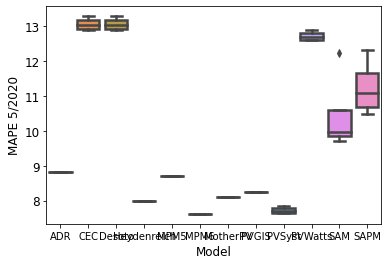

In [111]:
#ax = sns.boxplot(x = 'Model', y = 'MAPE 5/2020', data=meta, linewidth = 2.5)